<h1> TP Adversarial Networks</h1>

Ce TP est consacré à la manipulation de réseaux génératifs exploitant le paradigme d'apprentissage "Adversarial". Ce type de réseaux comprend une partie "Générateur" et une autre "Discriminateur", chacun ayant des objectifs antagonistes.

La première partie de ce TP illustre la capacité des GAN sur des données artificielles, sous la forme d'un mélange de gaussiennes 1D. Cette partie est fortement guidée et met en évidence la capacité des deux sous réseaux pour parvenir à approcher au mieux la distribution sous jacentes des données.

La deuxième partie nécessite un travail en autonomie. Elle consiste à étendre le réseau préalablement définie pour, cette fois, modéliser la distribution des données issues du jeu de données MNIST (les chiffres manuscrits).

Pour finir, vous pourriez vous amuser et générer des visages réalistes à partir du jeu de données CelebA.

In [1]:
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
import numpy as np

In [2]:
device = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(device[0], True)
device

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Partie 1: GANs avec des données artificielles</h2>

Dans la cellule suivante, on créé des données artificielles à partir de distributions gaussiennes. Par la suite, on modifiera le code pour obtenir des données multimodales (ie: mélange de gaussinnes).

In [3]:
batch_size = 10
nbdata = 250
data_dim = 1 

value_n = [5, 10, 15, 20, 2]

def generate_data(value_n, nbdata):
    xdata = []
    for n in value_n:
        xdata.append(np.random.normal(n, 0.1, (int(nbdata/len(value_n)), data_dim)))
    return np.concatenate(xdata)

xdata = generate_data(value_n, nbdata)
np.random.shuffle(xdata)


Affichage de la densité de distribution correspondant à nos données :

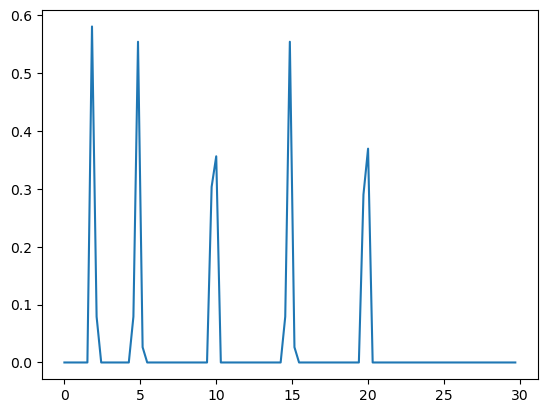

In [4]:
import matplotlib.pyplot as plt

xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)
hx,_ = np.histogram(xdata, bins=bins, density=True)

plt.plot(xs, hx)

<h2>Création d'un générateur python pour accéder aux données par batch</h2>

In [5]:
def get_batch():
  i = 0
  while True:
    i = i + batch_size
    if i+batch_size > nbdata: i = 0

    yield xdata[i:i+batch_size]

data_generator = get_batch()

# affiche un batch de données
x = next(data_generator)
print(x)

[[19.89603205]
 [ 9.79695707]
 [ 9.96627841]
 [ 9.898477  ]
 [10.09297875]
 [20.03392059]
 [14.88336772]
 [ 4.96733106]
 [14.98779059]
 [14.94426152]]


<h2> Création du réseau</h2>

Ici nous créons les deux parties : "générateur" et "discriminateur", puis le modèle combiné "GAN". Réseaux très simples comprenant deux couches cachées denses avec tanh + une couche sortie. Dropout dans le discriminateur.

In [6]:
# some hyperparameters
z_dim = 5
h_dim = 10

def generator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="relu", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(32, activation="relu"))
  model.add(keras.layers.Dense(64, activation="relu"))
  model.add(keras.layers.Dense(128, activation="tanh"))
  model.add(keras.layers.Dense(data_dim))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt)

print(G.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 32)                352       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,973
Trainable params: 10,973
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
def discriminator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="relu", input_shape=(data_dim,)))
  model.add(keras.layers.Dense(64, activation="relu"))
  model.add(keras.layers.Dense(32, activation="relu"))
  model.add(keras.layers.Dropout(0.4))

  model.add(keras.layers.Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

D = discriminator(opt)

print(D.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                20        
                                                                 
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,837
Trainable params: 2,837
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
def gan(opt):
  D.trainable = False
  GAN = keras.models.Sequential()
  GAN.add(G)
  GAN.add(D)
  GAN.compile(loss="binary_crossentropy", optimizer=opt)
  return GAN

GAN = gan(opt)
print(GAN.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 10973     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2837      
                                                                 
Total params: 13,810
Trainable params: 10,973
Non-trainable params: 2,837
_________________________________________________________________
None


<h2>Apprentissage du modèle</h2>

Initialisation de structures pour construire des plots

In [9]:
xtab = []
gtab = []
lossDtab = []
lossGtab = []
Dpostab = []
Dnegtab = []

epochs_done = 0

La boucle d'apprentissage alterne entre l'entrainement du discriminateur et du réseau composite "GAN".

Afin d'illustrer le fonctionnement de ce type de réseau, on enregistre les valeurs de loss du discriminateur (lossD) et du générateur (lossG), ainsi que les prédictions du discriminateur pour des exemples positifs (Dpos) et négatifs (Dneg). On conserve l'historique dans des listes pour affichage ultérieur. On enregistre aussi des données obtenues par le générateur à chaque epoch, ces données seront utilisées et animées dans une cellule suivante.

La conservation de ces différents éléments ralentit fortement l'entrainement. Attendez 3 minutes pour quelques exécutions puis commentez les instructions non nécessaires à l'entrainement du réseau.

In [10]:
data_generator = get_batch()
nb_epoch = 60
nb_batchs = 10
ones = np.ones((batch_size, 1))
zeros = np.zeros((batch_size, 1))
for epoch in range(nb_epoch):
  lossD = []
  lossG = []
  Dpos = []
  Dneg = []
  for batch in range(nb_batchs):

    # train discriminator with positive samples
    x = next(data_generator)
    lossP = D.train_on_batch(x, ones) # the discriminator must predict 1 for real samples

    if epoch % 10 == 0: # trace logits for plotting
      x = next(data_generator)
      Dpos.append( D.predict(x) )

    # train discriminator with negative samples
    z = K.random_uniform((batch_size, z_dim), -1, 1)
    fakes = G.predict(z) # feed generator with random vectors to get fakes
    lossN = D.train_on_batch(fakes, zeros) # discriminator must predict 0 for fakes

    if epoch % 10 == 0: # trace logits for plotting
      z = K.random_uniform((batch_size, z_dim), -1, 1)
      fakes = G.predict(z)
      Dneg.append( D.predict(fakes) )

    # compute D's loss (for plotting)
    lossD.append((lossP + lossN) / 2.)

    # train generator with GAN composite model
    z = K.random_uniform((batch_size, z_dim), -1, 1)
    lossG.append( GAN.train_on_batch(z, ones) ) # must predict 1

  # Compute and store statistics for further plotting
  if epoch % 10 == 0:
    lossD = np.mean(lossD)
    lossG = np.mean(lossG)
    Dpos = np.mean(Dpos)
    Dneg = np.mean(Dneg)

    lossDtab.append(lossD)
    lossGtab.append(lossG)
    Dpostab.append(Dpos)
    Dnegtab.append(Dneg)

    print(epoch, " lossD=", lossD, " lossG=", lossG, " Dpos=", Dpos, " Dneg=", Dneg )

  # Sample data from generator to plot an animation of learned distribution
  z = K.random_uniform((10*batch_size, z_dim), -1, 1)
  g = G.predict(z)
  hg,_ = np.histogram(g, bins=bins, density=True)
  gtab.append(hg)
  xtab.append(hx)

  epochs_done = epochs_done + 1

1/1 [==============================] - 0s 12ms/step
0  lossD= 0.6718355417251587  lossG= 0.657545006275177  Dpos= 0.6953021  Dneg= 0.5164485
1/1 [==============================] - 0s 13ms/step
10  lossD= 0.7006229817867279  lossG= 0.660920524597168  Dpos= 0.51515806  Dneg= 0.50768954
1/1 [==============================] - 0s 12ms/step
20  lossD= 0.7117407262325287  lossG= 0.7025446474552155  Dpos= 0.50565386  Dneg= 0.4969257
1/1 [==============================] - 0s 13ms/step
30  lossD= 0.6983492583036423  lossG= 0.725827831029892  Dpos= 0.4853397  Dneg= 0.4832291
1/1 [==============================] - 0s 13ms/step
40  lossD= 0.6933302581310272  lossG= 0.672914695739746  Dpos= 0.5118436  Dneg= 0.5091038
1/1 [==============================] - 0s 12ms/step
50  lossD= 0.6977728486061097  lossG= 0.670949375629425  Dpos= 0.5069025  Dneg= 0.5093335
4/4 [==============================] - 0s 2ms/step


<h2>Création et affichage des plots</h2>


<b>1. Evolution des prédictions du discriminateur sur les données réelles (en bleu) ou sur les données fournies par le générateur (en vert).</b>
On observe une convergence rapide vers 0.5, le point d'équilibre lorsque le discriminateur ne sait plus distinguer l'origine des données.

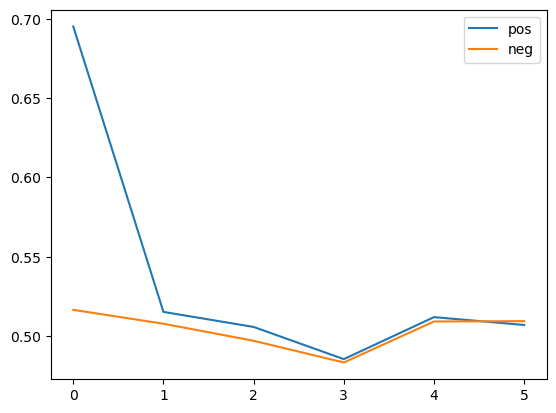

In [11]:
ppos, = plt.plot(Dpostab, label="pos")
pneg, = plt.plot(Dnegtab, label="neg")
plt.legend(handles=[ppos, pneg])

<b>2. Evolution des données obtenues au cours de l'apprentissage.</b>
Selon le nombre d'epochs, la cellule suivante prend un peu de temps pour construire un gif que nous affichons dans la foulée. Cette étape nécessite l'installation du package ffmeg-python.

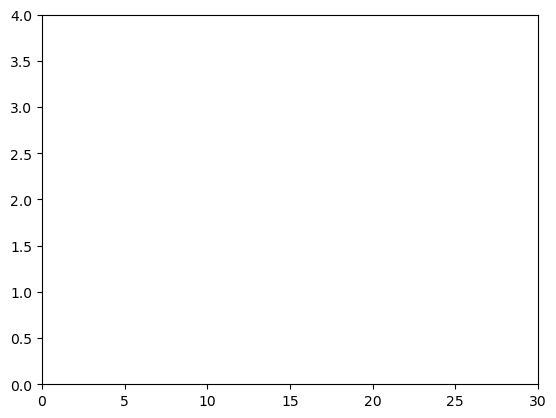

In [12]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=False)
rc('animation', html='jshtml')
anim


<b>3. Comparaison entre un batch de données original et de données issues du générateur.</b>

some real data: [[15.05961567]
 [15.00618319]
 [20.01633328]
 [ 4.98380297]
 [ 5.16009804]
 [14.8244448 ]
 [ 5.04813676]
 [ 5.11367077]
 [19.89508584]
 [10.03171299]]
4/4 [==============================] - 0s 2ms/step
some generated data [[17.599491]
 [17.778942]
 [18.332949]
 [17.072557]
 [16.389097]
 [15.066964]
 [16.865936]
 [16.194906]
 [17.626328]
 [17.127394]]


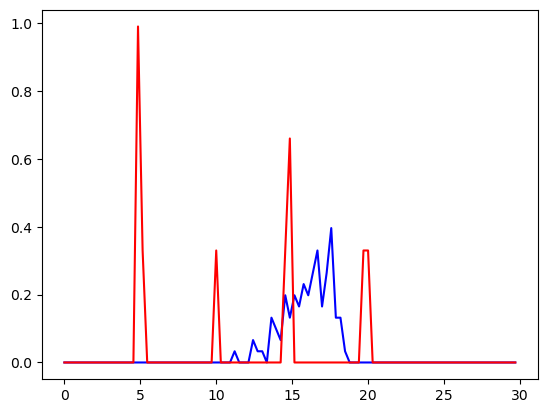

In [13]:
# get a batch of real data (for comparison)
x = next(data_generator)
print("some real data:", x)

# sample some noise then transform them with our generator
z = np.random.uniform(-1,1,(10*batch_size, z_dim))
g = G.predict(z)
print("some generated data", g[:10])

# plot distributions
xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)

hg,_ = np.histogram(g, bins=bins, density=True)
plt.plot(xs,hg,  c="blue")

hx,_ = np.histogram(x, bins=bins, density=True)
plt.plot(xs,hx, c="red")
plt.show()

# Travail à faire

1. Modifiez la première fonction de création de données pour obtenir la moitiée de données centrées autour de 5 et l'autre autour de 10. La distribution de probabilité associée à ces données est dite "multimodale" (2 modes).

2. Réinitialisez les modèles et relancez l'apprentissage. Essayez plus d'epoch si besoin.

3. Augmentez les capacités du discriminateur et générateur en augmentant leur nombre de neurones dans les couches cachées.

4. Augmentez de nouveau le nombre de modes de la distribution de données et retentez l'expérience. La difficulté de parvenir à apprendre des distributions multimodales correspond au "mode collapse" dans la littérature GAN. Une manière de contourner ce problème consiste à encourager le discriminateur à reconnaitre une diversité dans un batch d'exemples. Plusieurs approches ont été proposées dans ce sens, dont "batch discrimination" et "standard deviation discrimination" (à voir dans la littérature).

<h2>Partie 2: Adversarial Autoencoder sur Fashion-MNIST</h2>

https://keras.io/api/datasets/fashion_mnist/

Cette partie se déroule en totale autonomie. Une fois bien compris la partie précédente, proposez un réseau autoencoder pour générer des images de vêtements en 28x28 pixels (et/ou des visages pour les très motivés).

Plutôt que de suivre l'approche variationnelle VAE, implémentez la variante avec contrainte adversariale AAE où un discriminateur contraint l'encodeur pour qu'il produise des vecteurs similaires à des tirages d'une distribution a priori (ie: Normale ou Uniforme).

Pour le jeu de données Fashion MNIST, les réseaux pourront exploiter des couches Dense, Conv2D, MaxPooling2D et UpSampling2D. L'espace latent intermédiaire ne devrait pas dépasser 10) 20 neurones pour encoder la variabilité des formes du jeu de données.



In [40]:
from keras.datasets.fashion_mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()

In [74]:
data_dim = 28 * 28
z_dim = 5 # espace latent

In [75]:
def encodeur():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(data_dim,)))
    model.add(keras.layers.Dense(16, activation="relu"))
    model.add(keras.layers.Dense(32, activation="relu"))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(z_dim ))
    return model

In [76]:
def decodeur(opt):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(z_dim,)))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(data_dim, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

In [77]:
def discriminateur(opt, z_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, activation="relu", input_shape=(z_dim,)))
    model.add(keras.layers.Dense(32, activation="relu"))
    model.add(keras.layers.Dense(16, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

In [78]:
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.99)

In [79]:
en = encodeur()
de = decodeur(opt)
di = discriminateur(opt, z_dim)

In [80]:
def adversial_auto_encodeur(opt):
    model_ae = keras.models.Sequential()
    model_ae.add(en)
    model_ae.add(de)
    model_ae.compile(loss="binary_crossentropy", optimizer=opt)

    model_en_di = keras.models.Sequential()
    model_en_di.add(en)
    model_en_di.add(di)
    model_en_di.compile(loss="binary_crossentropy", optimizer=opt)

    return model_en_di, model_ae

In [81]:
model_en_di, model_ae = adversial_auto_encodeur(opt)

In [82]:
def get_batch(data, batch_size):
    while True:
        idx = np.random.randint(0, data.shape[0], batch_size)
        batch = data[idx]
        batch = batch.astype('float32') / 255.0
        batch = batch.reshape((-1, 28 * 28))
        yield batch

In [83]:
data_generator = get_batch(x_train, batch_size)
lossDtab = []
lossGtab = []
lossAEtab = []

for epoch in range(nb_epoch):
    lossD = []
    lossG = []
    lossAE = []
    for batch in range(nb_batchs):
        z_real = np.random.normal(0, 1, (batch_size, z_dim))
        d_loss_real = di.train_on_batch(z_real, np.ones((batch_size, 1)))

        x_real = next(data_generator)
        z_fake = en.predict(x_real)
        d_loss_fake = di.train_on_batch(z_fake, np.zeros((batch_size, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        lossD.append(d_loss)

        g_loss = model_en_di.train_on_batch(x_real, np.ones((batch_size, 1)))
        lossG.append(g_loss)

        ae_loss = model_ae.train_on_batch(x_real, x_real)
        lossAE.append(ae_loss)

    lossDtab.append(np.mean(lossD))
    lossGtab.append(np.mean(lossG))
    lossAEtab.append(np.mean(lossAE))

    print(f"Epoch {epoch + 1}/{nb_epoch} | Loss D: {np.mean(lossD):.4f} | Loss G: {np.mean(lossG):.4f} | Loss AE: {np.mean(lossAE):.4f}")


1/1 [==============================] - 0s 12ms/step
Epoch 1/60 | Loss D: 0.7526 | Loss G: 0.6744 | Loss AE: 0.6708
1/1 [==============================] - 0s 12ms/step
Epoch 2/60 | Loss D: 0.7964 | Loss G: 0.4911 | Loss AE: 0.5495
1/1 [==============================] - 0s 11ms/step
Epoch 3/60 | Loss D: 0.7212 | Loss G: 0.5240 | Loss AE: 0.5442
1/1 [==============================] - 0s 12ms/step
Epoch 4/60 | Loss D: 0.6841 | Loss G: 0.5335 | Loss AE: 0.5409
1/1 [==============================] - 0s 13ms/step
Epoch 5/60 | Loss D: 0.8531 | Loss G: 0.4632 | Loss AE: 0.5227
1/1 [==============================] - 0s 12ms/step
Epoch 6/60 | Loss D: 0.9723 | Loss G: 0.4370 | Loss AE: 0.5292
1/1 [==============================] - 0s 13ms/step
Epoch 7/60 | Loss D: 1.3885 | Loss G: 0.4294 | Loss AE: 0.5221
1/1 [==============================] - 0s 12ms/step
Epoch 8/60 | Loss D: 1.6717 | Loss G: 0.4413 | Loss AE: 0.5272
1/1 [==============================] - 0s 12ms/step
Epoch 9/60 | Loss D: 1.6679 

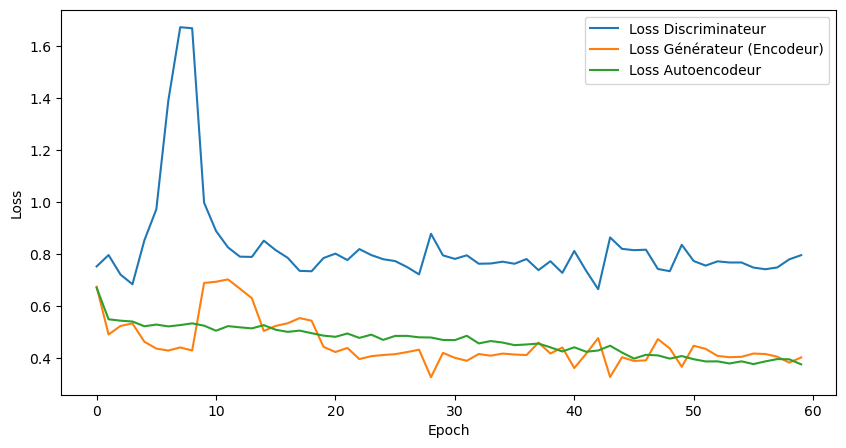

In [84]:
plt.figure(figsize=(10,5))
plt.plot(lossDtab, label='Loss Discriminateur')
plt.plot(lossGtab, label='Loss Générateur (Encodeur)')
plt.plot(lossAEtab, label='Loss Autoencodeur')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

1/1 [==============================] - 0s 40ms/step


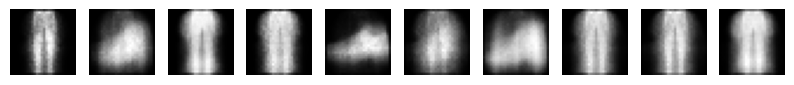

In [85]:
z_random = np.random.normal(0, 1, (10, z_dim))
generated_images = de.predict(z_random)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()